# **Digital Signal and Image Management - E04**<br/>
**Master's Degree in Data Science (A.Y. 2022/2023)**<br/>
**University of Milano - Bicocca**<br/>

prof. Simone Bianco, 
dr. Marco Buzzelli

In [1859]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv # OpenCV

# Verify OpenCV version
print(cv.__version__)

4.6.0


https://docs.opencv.org/4.6.0/da/df5/tutorial_py_sift_intro.html<br/>
https://docs.opencv.org/4.6.0/d1/d89/tutorial_py_orb.html<br/>
https://docs.opencv.org/4.6.0/df/dd2/tutorial_py_surf_intro.html

**Note:**
* SIFT stands for Scale-Invariant Feature Transform
* SIFT support was included in a previous version of OpenCV, later removed due to patents issues, and finally reincluded in version 4.4
* If you cannot get (locally) a recent version of OpenCV, you can also consider installing an older version that supports SIFT:
  * `pip install opencv_contrib_python==3.4.2.17 --force-reinstall`
  * `conda install -c menpo opencv`
* Some commands might expose a slightly different syntax, e.g.:
  * `cv.xfeatures2d.SIFT_create()` instead of `cv.SIFT_create()`
* Alternatively, it is possible to use open-source alternatives to SIFT, such as ORB or SURF

In [1860]:
# Set visualization size for figures (notebook only)
plt.rcParams['figure.figsize'] = [15, 5] # width, height

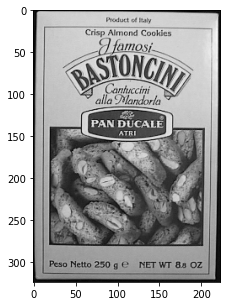

In [1861]:
# Load image
box = cv.imread('box.png', cv.IMREAD_GRAYSCALE)
plt.imshow(box, cmap='gray'); plt.show()

https://docs.opencv.org/4.6.0/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56<br/>
https://docs.opencv.org/4.6.0/d8/d6a/group__imgcodecs__flags.html#ga61d9b0126a3e57d9277ac48327799c80

**Note:**
* We will process the image using OpenCV, so it makes sense to also load it with OpenCV itself
* The second parameter forces the image to be imported as grayscale (single-channel)
* OpenCV documentation usually incluedes both C++ and Python signatures

## SIFT detection and description

In [1862]:
# Creating an instance for SIFT
sift = cv.SIFT_create()

https://docs.opencv.org/4.6.0/d7/d60/classcv_1_1SIFT.html#ad337517bfdc068ae0ba0924ff1661131<br/>

**Note:**
* SIFT keypoints are image regions that are highly characteristic/discriminative
  * I.e. they can be useful to recognize the same image in a different context
* A good keypoint would be a corner, or a letter
* A bad keypoint would be a uniform region

In [1863]:
# SIFT detection and description
(kps1, features1) = sift.detectAndCompute(box, None)

https://docs.opencv.org/4.6.0/d0/d13/classcv_1_1Feature2D.html#a8be0d1c20b08eb867184b8d74c15a677

**Note:**
* `detectAndCompute()` produces two outputs:
  * `keypoints`: the coordinates of each keypoint center position
  * `descriptors`: a feature vector that characterizes each keypoint surrounding area
* By design, SIFTs are rotation-invariant:<br/>
     a corner will have the same descriptor, regardless of its orientation.

In [1864]:
# Number of detected keypoints
len(kps1)

604

In [1865]:
# Corresponding descriptors
features1.shape

(604, 128)

**Note:**
* In this image, we have found 604 regions that are potentially useful to identify the same object in a different context.
* Each descriptor is a 128-elements-long feature vector
* Each keypoint is a custom class (see following)

In [1866]:
# Available information for each keypoint
print(type(kps1[0]))
print(dir(kps1[0]))

<class 'cv2.KeyPoint'>
['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'angle', 'class_id', 'convert', 'octave', 'overlap', 'pt', 'response', 'size']


**Note:**
* Using `dir()` we can get the list of attributes and methods for a custom class, such as `cv2.KeyPoint`.
  * The most important ones, which are specific for the class, are found at the end of the list (their names do not begin with an underscore)
* Each keypoint is associated to the following information:
  * A 128-dimensional descriptor (external variable, called ``features1`` in our case)
  * A set of properties (which can be accessed directly from the keypoint itself):
    * `angle`:<br/>
      In case we do **not** want rotation-invariance, we can use this information.
    * `class_id`
    * `octave`:<br/>
      The image is scanned for keypoints at various resolutions.<br/>
      This indicates the scale at which the current keypoint was found.
    * `pt`:<br/>
      This contains the actual coordinates of the keyopint.
    * `response`
    * `size`


In [1867]:
# Example: coordinates of the first keypoint
kps1[0].pt

(3.1613831520080566, 204.0614776611328)

In [1868]:
np.array(kps1[0].pt)

array([  3.16138315, 204.06147766])

### Keypoint visualization

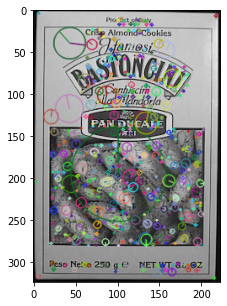

In [1869]:
# SIFT keypoints visualization
box_kps = cv.drawKeypoints(box, kps1, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(box_kps); plt.show()

https://docs.opencv.org/4.6.0/d4/d5d/group__features2d__draw.html#ga5d2bafe8c1c45289bc3403a40fb88920

**Note:**
* Some keypoints are **apparently** in uniform regions (see top left area)
* In practice, this is identified as being enclosed by two lines at a specific relative angle

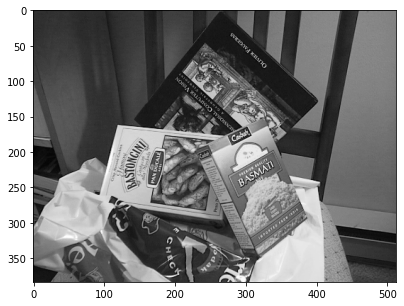

In [1870]:
# Load the background image
scene = cv.imread('box_in_scene.png', cv.IMREAD_GRAYSCALE)
plt.imshow(scene, cmap='gray'); plt.show()

In [1871]:
# Detect and describe SIFT keypoints on the second image
(kps2, features2) = sift.detectAndCompute(scene, None)

## Matching

In [1872]:
# Find correspondences (matches) between the two images
bf = cv.BFMatcher.create(crossCheck=True)
matches = bf.match(features1, features2)

https://docs.opencv.org/4.6.0/dc/dc3/tutorial_py_matcher.html<br/>
https://docs.opencv.org/4.6.0/d3/da1/classcv_1_1BFMatcher.html#ac6418c6f87e0e12a88979ea57980c020<br/>
https://docs.opencv.org/4.6.0/db/d39/classcv_1_1DescriptorMatcher.html#a0f046f47b68ec7074391e1e85c750cba

**Note:**
* We want to find a correspondence between (some) descriptors of the first image, and (some) descriptors of the second image.
* We will use a 'Brute Force' matcher:
  * Each descriptor from the first image is compared with all descriptors from the second image
  * The keypoint location is ignored
  * The features are compared with a metric, and the most similar is selected (if similarity is above a given threshold)
* `crossCheck=True` requires that 'most similar' runs in both directions:
  * Given a keypoint from image 1, we find its most similar from image 2
  * Given that most similar keypoint from image 2, we check that its most similar from image 1 is the keypoint we started with.

In [1873]:
# Number of matches between the two images
len(matches)

258

In [1874]:
# Information associated to each match
print(type(matches[0]))
print(dir(matches[0]))

<class 'cv2.DMatch'>
['__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'distance', 'imgIdx', 'queryIdx', 'trainIdx']


**Note:**
* `matches` is a list, and each element 'connects' a keypoint from image 1 with a keypoint from image 2.
* Each match is associated to the following information:
  * `distance`:<br/>
     this does **not** refer to spatial distance, in fact remember that we are currently ignoring the keypoints location.
     Instead, it refers to distance in feature space, i.e. dissimilarity.
  * `imgIdx`
  * `queryIdx`:<br/>
     This is the keypoint *index* from the first image (`box`)
  * `trainIdx`:<br/>
     This is the keypoint *index* from the second image (`box_in_scene`)

In [1875]:
# Examples: details of the first match.

In [1876]:
# Keypoint index of the first image (box)
matches[0].queryIdx

0

In [1877]:
# Keypoint index of the second image (scene)
matches[0].trainIdx

881

**Note:**
* This is is interpreted as:<br/>
  the descriptor of keypoint number 0 from the first image, is very similar to the descriptor of keypoint number 881 from the second image.

### Visualization of the matches

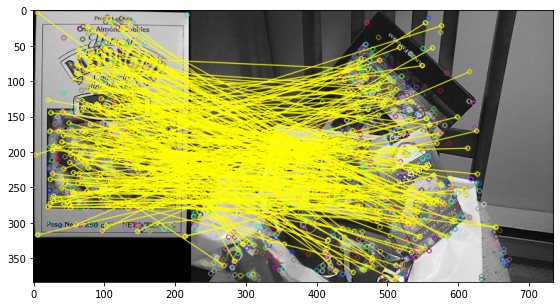

In [1878]:
# Visualization of the matches
result = cv.drawMatches(box, kps1, scene, kps2, matches, None, matchColor=[255,255,0])
plt.imshow(result); plt.show()

https://docs.opencv.org/4.6.0/d4/d5d/group__features2d__draw.html#gad8f463ccaf0dc6f61083abd8717c261a

**Note:**
* The set of matches contains many false positives.
* One possible solution is to sort the matches starting from the most confident ones (i.e. those with very similar descriptors, i.e. with low value of distance), and limit the visualization to the first N matches

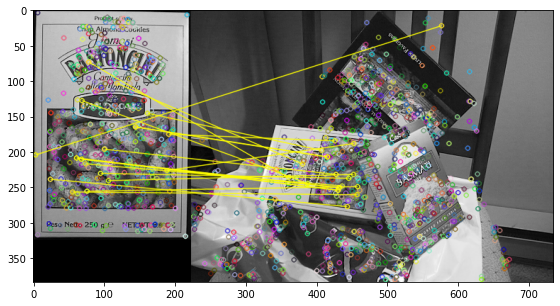

In [1879]:
# Visualization of only filtered matches
matches = sorted(matches, key=lambda x:x.distance)
result = cv.drawMatches(box, kps1, scene, kps2, matches[0:20], None, matchColor=[255,255,0])
plt.imshow(result); plt.show()

**Note:**
* `sorted` is a native python function
* However, `matches` is not a native type, such as integers, so `sorted` would not know how to handle it (which criterion to use for sorting)
* We create an on-the-fly function (lambda function) that takes an input (renamed `x`) and returns its `distance` property.
  * This value will be used by `sorted` to perform its sorting.

## Assignment: Photo stitching

**Approach:**
1. Use a pair of custom images (different from the ones provided).
   * The two images must have a partial overlap
2. Extract keypoints and find matches (no sorting/filtering matches is needed here)
3. Find the homography which describes the transformation from the second set of points to the first one
4. Apply the homography to the second image
5. Integrate the first image

It is not allowed to use `cv.createStitcher()` or other complete functions for image stitching.<br/>
You should, however, use pre-made functions for the computation of the homography and for image warping.

In [1880]:
# Image loading
im1 = cv.imread('boat1.jpg', cv.IMREAD_GRAYSCALE)
im2 = cv.imread('boat3.jpg', cv.IMREAD_GRAYSCALE)

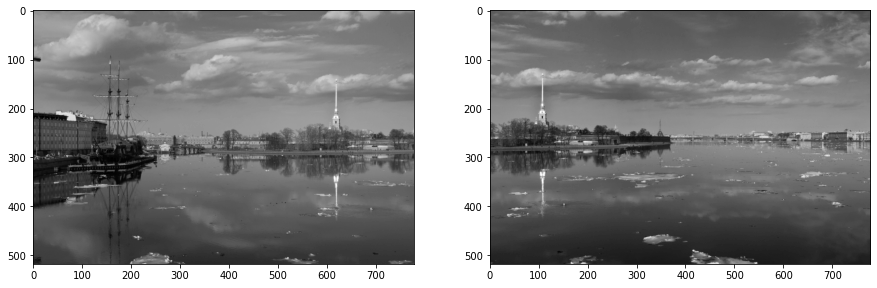

In [1881]:
plt.subplot(1,2,1); plt.imshow(im1, cmap='gray');
plt.subplot(1,2,2); plt.imshow(im2, cmap='gray');
plt.show()

**Note:**
* The right part of the first image has the same content as the left part of the second image
* We will extract keypoints from the two, and find the matches (which will be only in the overlapping regions)

In [1882]:
# Keypoints extraction
sift = cv.SIFT_create()
(kps1, features1) = sift.detectAndCompute(im1, None)
(kps2, features2) = sift.detectAndCompute(im2, None)
# Features matching
bf = cv.BFMatcher.create(crossCheck=True)
matches = bf.match(features1, features2)

### 1. Find the homography which describes the transformation from the <u>second</u> set of points to the <u>first</u> one

In [1883]:
def myHomography(kps1, kps2, matches):
    # utilizzo i punti corrispondenti nelle due immagini per trovare l'omografia tramite RANSAC
    points1 = np.float32([kps1[m.queryIdx].pt for m in matches])
    points2 = np.float32([kps2[m.trainIdx].pt for m in matches])
    H = cv.findHomography(points2, points1, cv.RANSAC)
    return H

https://docs.opencv.org/4.6.0/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780

**Note:**
* We have previously determined the correspondences between locations in the two images.
* We now determine the *perspective transformation* that will displace all pixels of the second image following such correspondences.
  * This transformation is also called 'homography', and it can be represented with a 3$\times$3 linear matrix
* When defining the homography, we can use RANSAC (RANdom SAmple Consensus) to improve these correspondences:
  * We do not want a transformation that is a compromise between all correspondences, as some of them are just mistakes from the Matching algorithm.
  * Instead, we want a transformation that is very well in agreement by the majority of found correspondences.
  * To achieve this, RANSAC will take 4 random matches, which are sufficient to determine a homography, and it verifies how much all other matches are well described by this transformation.
  * This process is repeated a number of times, and the transformation with the best agreement is selected as homography.

In [1884]:
H = myHomography(kps1, kps2, matches)

In [1885]:
H = H[0]
print(H)

[[ 5.69534898e-01 -3.24168884e-03  5.20536833e+02]
 [-1.53429459e-01  9.22489310e-01  2.95572137e+01]
 [-5.53445930e-04 -9.11697723e-06  1.00000000e+00]]


**Note:**
* You might get slightly different results, due to the non deterministic nature of RANSAC

### 2. Apply the homography to the second image

Per calcolare la grandezza dell'immagine di output, richiesta come parametro dalla funzione `cv.warpPerspective()`, si è in un primo approccio voluta calcolare l'**immagine** (tramite H) del punto in basso a destra dell'immagine di partenza.

In [1886]:
def myWarp2(im, H):
    rows,cols = im.shape
    X = np.dot(H, np.array([[cols],[rows],[1]]))      # risolvo sistema lineare con input il punto basso dx
    X = X/X[2]
    warped_image = cv.warpPerspective(im,H,(int(X[0]),int(X[1])))   # imposto la posizione del punto come dimensione dell'immagine risultante
    return [warped_image,int(X[0]),int(X[1])]     # ritorno l'immagine e il punto trovato

https://docs.opencv.org/4.6.0/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87<br/>
https://docs.opencv.org/4.6.0/da/d6e/tutorial_py_geometric_transformations.html

**Note:**
* A linear transformation is applied with the rules of matrix multiplication:<br/>
$
\begin{bmatrix}
x_{out}' \\
y_{out}' \\
z_{out}'
\end{bmatrix}
 = \begin{bmatrix}
h_{11} & h_{12} & h_{13} \\
h_{21} & h_{22} & h_{23} \\
h_{31} & h_{32} & h_{33} 
\end{bmatrix}
\begin{bmatrix}
x_{in} \\
y_{in} \\
1
\end{bmatrix}$
* The output coordinates are 3-dimensional. Since we need 2-dimensional coordinates (pixel rows and columns), we must normalize by the third component:<br>
$x_{out} = \dfrac{x'_{out}}{z'_{out}}$<br/>
$y_{out} = \dfrac{y'_{out}}{z'_{out}}$
* In other terms, the output coordinates are computed as:<br/>
$x_{out} = \dfrac{h_{11}\cdot x_{in} + h_{12}\cdot y_{in} + h_{13}}{h_{31}\cdot x_{in} + h_{32}\cdot y_{in} + h_{33}}$<br/>
$y_{out} = \dfrac{h_{21}\cdot x_{in} + h_{22}\cdot y_{in} + h_{23}}{h_{31}\cdot x_{in} + h_{32}\cdot y_{in} + h_{33}}$
* This is an explanation of what happens when applying perspective warping with homographies.
* You are not expected to write your own function for warping, but to appropriately use the ones provided by OpenCV.

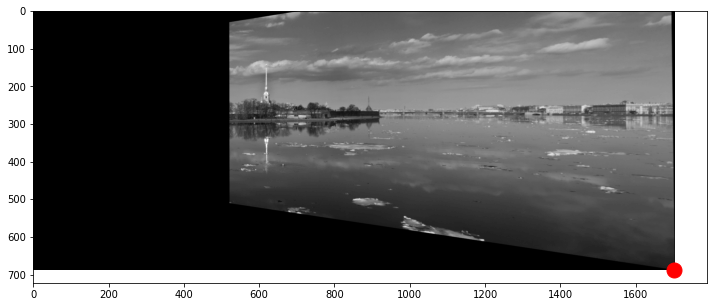

In [1887]:
# Apply a perspective warp to stitch the images together
temp,x_imm,y_imm = myWarp2(im2, H)
plt.imshow(temp, cmap='gray'); 
plt.plot(x_imm, y_imm, "or", markersize=15)     # plot del punto trovato
plt.show()

Come si vede però, si viene a creare una piccola striscia nera sulla destra a causa della prospettiva. Si è deciso quindi di andare ad individuare il punto della prima riga più a destra possibile prima di entrare nella zona della striscia nera.
Per fare ciò si è utilizzata l'equazione $y_{out} = \dfrac{h_{21}\cdot x_{in} + h_{22}\cdot y_{in} + h_{23}}{h_{31}\cdot x_{in} + h_{32}\cdot y_{in} + h_{33}}$ di cui sappiamo il valore di $y_{out}$ e di $x_{in}$ poichè sono rispettivamente 0 (vogliamo che il punto finisca nella prima riga della nostra immagine) e il numero di colonne dell'immagine (poichè stiamo prendendo come input un punto sul bordo a destra della nostra immagine). Risolvendo così nella variabile $y_{in}$ abbiamo entrambe le coordinate del punto che andrà a finire in alto a destra prima della striscia nera. Non ci rimane che moltiplicare H per tale punto e otteremo il punto di output che volevamo.


In [1888]:
# import per calcolo simbolico
from sympy.solvers import solve
from sympy import Symbol

In [1889]:
def myWarp(im, H):
    rows,cols = im.shape
    # risolvo l'equazione indicata precedentemente nella cella di testo
    y_in = Symbol('y_in')
    y_input = solve((H[1][0]*cols + H[1][1]*y_in + H[1][2])/(H[2][0]*cols + H[2][1]*y_in + H[2][2]), y_in)
    # moltiplico H per il punto input
    X = np.dot(H, np.array([[cols],[int(y_input[0])],[1]]))
    X = X/X[2]
    # per la dim dell'immagine come colonne prendo la coordinata del punto trovato
    # mentre come righe metto quelle dell'immagine originale (#righe uguale a immagine da attaccare successivamente)
    warped_image = cv.warpPerspective(im,H,(int(X[0]),rows))    
    return [warped_image,int(X[0]),int(X[1])]

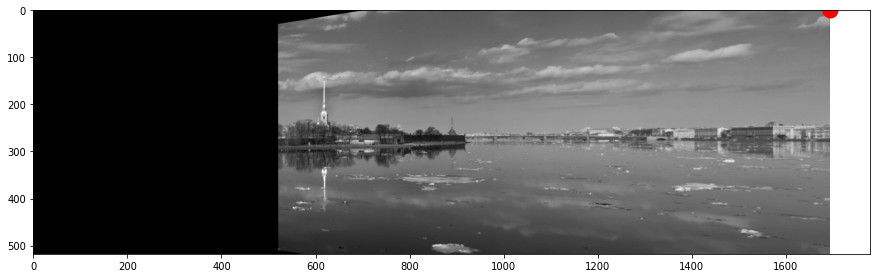

In [1890]:
# Apply a perspective warp to stitch the images together
temp,x_imm,y_imm = myWarp(im2, H)
plt.imshow(temp, cmap='gray'); 
plt.plot(x_imm, y_imm, "or", markersize=15)     # plot del nuovo punto trovato
plt.show()

Ora non rimane che aggiungere nella parte a sinistra l'altra immagine.

### 3. Integrate the first image

``im_base[from_y:to_y, from_x:to_x] = im_new``

In [1891]:
def myCollage(im_base, im_new):
    # seleziono la parte di im_base che deve essere occupata dalla seconda immagine
    im_base[0:im_new.shape[0], 0:im_new.shape[1]] = im_new
    return im_base

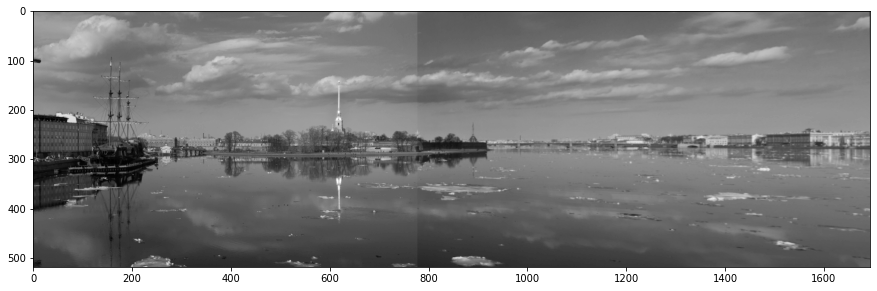

In [1892]:
result = myCollage(temp, im1)
plt.imshow(result, cmap='gray'); plt.show()

**Note:**
* The two images are now 'registered'.
* We notice an artifact: the first image was shot with higher exposure, and thus it is brighter.
* Techniques for reducing these differences can be deployed, but are not requested for the assignment.

Per aggiustare la differenza di luminosità tra le due immagini viene quindi applicata una gamma correction alla prima immagine per renderla più scura.

In [1893]:
def myGammaCorrection(im, gamma):
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256):
      lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    res = cv.LUT(im, lookUpTable)
    return res

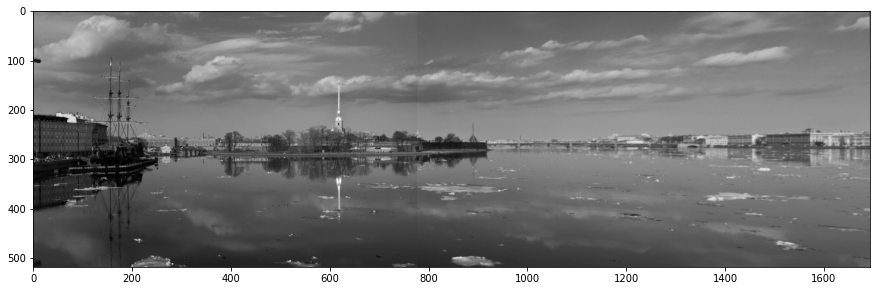

In [1894]:
im1_gamma_corr = myGammaCorrection(im1, 1.13)
result = myCollage(temp, im1_gamma_corr)
plt.imshow(result, cmap='gray'); plt.show()

Nonstante si noti ancora il passaggio da un'immagine all'altra, quest'ultimo risulta meno evidente.

Infine si è deciso per rendere meno netto il passaggio da una immagine all'altra di utilizzare un filtro gaussiano nella zona di passaggio. Non si può sfocare troppo perchè altrimenti tutti i dettagli della zona vengono focati ed il risultato diventa peggiore del punto di partenza.

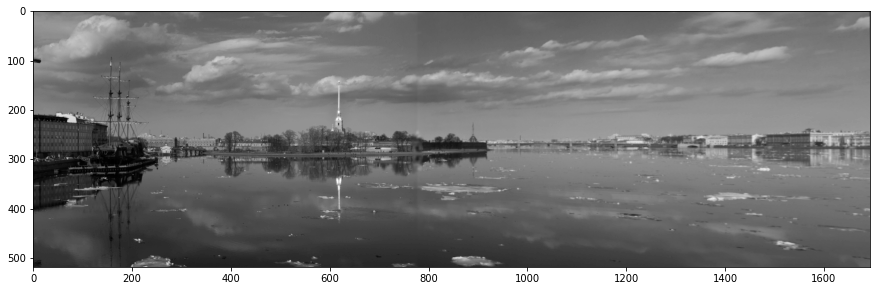

In [1895]:
# calcolo l'immagine filtrata per intero per utilizzare l'informazione dell'intorno della zona interessata.
# Sfocando solo la zona interessata si sarebbe dovuto usare il padding che sicuramente sarebbe risultato
# meno preciso (qualunque tipo di padding si fosse scelto) rispetto ai pixel della vera immagine
blur_zone = cv.GaussianBlur(result, (5,5), 4, cv.BORDER_DEFAULT)
# inserisco la parte di immagine sfocata nell'immagine result
result[:,(im1.shape[1] - 10):(im1.shape[1] + 10) ] = blur_zone[:, (im1.shape[1] - 10):(im1.shape[1] + 10) ]
plt.imshow(result, cmap='gray'); plt.show()

### Applicazione su immagini a scelta

In [1896]:
# Image loading
im1 = cv.imread('img_1.png', cv.IMREAD_GRAYSCALE)
im2 = cv.imread('img_2.png', cv.IMREAD_GRAYSCALE)

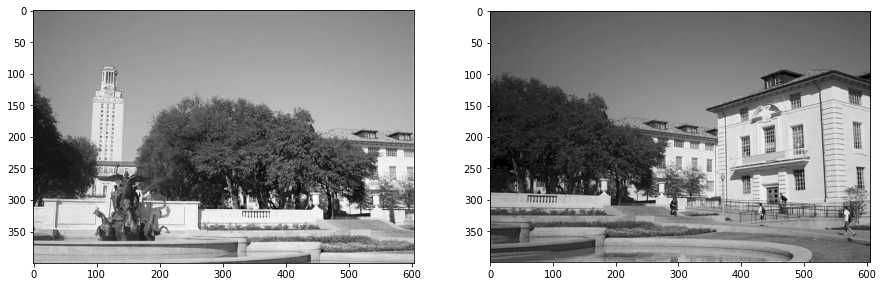

In [1897]:
plt.subplot(1,2,1); plt.imshow(im1, cmap='gray');
plt.subplot(1,2,2); plt.imshow(im2, cmap='gray');
plt.show()

In [1898]:
# Keypoints extraction
sift = cv.SIFT_create()
(kps1, features1) = sift.detectAndCompute(im1, None)
(kps2, features2) = sift.detectAndCompute(im2, None)
# Features matching
bf = cv.BFMatcher.create(crossCheck=True)
matches = bf.match(features1, features2)

In [1899]:
H = myHomography(kps1, kps2, matches)

In [1900]:
H = H[0]
print(H)

[[ 7.65374542e-01  3.85087097e-02  2.61654881e+02]
 [-1.35671397e-01  9.12508484e-01  4.58809102e+01]
 [-3.59608675e-04 -5.30211836e-05  1.00000000e+00]]


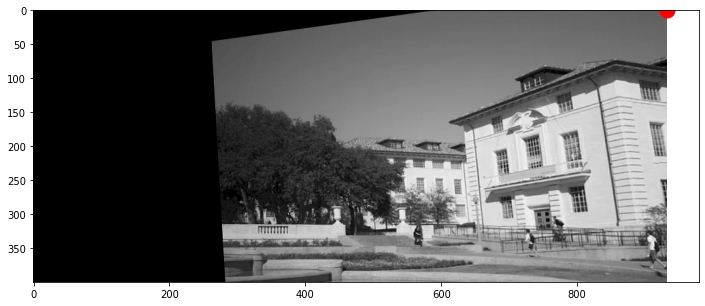

In [1901]:
# Apply a perspective warp to stitch the images together
temp,x_imm,y_imm = myWarp(im2, H)
plt.imshow(temp, cmap='gray'); 
plt.plot(x_imm, y_imm, "or", markersize=15)
plt.show()

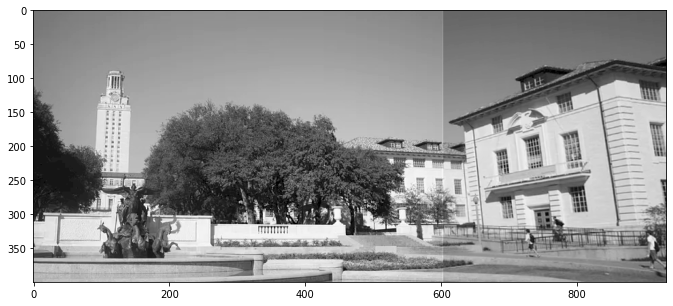

In [1902]:
result = myCollage(temp, im1)
plt.imshow(result, cmap='gray'); plt.show()

Per aggiustare la differenza di luminosità tra le due immagini viene quindi applicata una gamma correction alla prima immagine per renderla più scura.

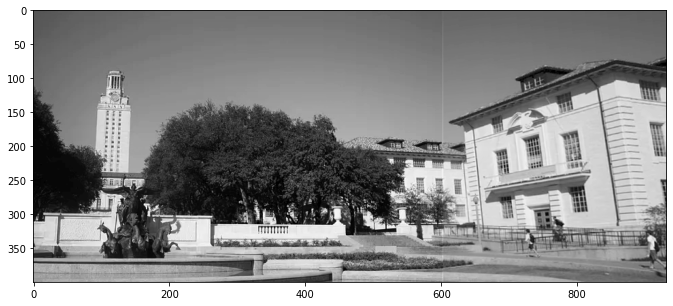

In [1903]:
im1_gamma_corr = myGammaCorrection(im1, 1.4)
result = myCollage(temp, im1_gamma_corr)
plt.imshow(result, cmap='gray'); plt.show()

Nonstante si noti ancora il passaggio da un'immagine all'altra, quest'ultimo risulta molto meno evidente.

Infine si è deciso per rendere meno netto il passaggio da una immagine all'altra di utilizzare un filtro nella zona di passaggio. In questo caso dato che la linea di passaggio era molto netta e stretta si è deciso di utilizzare un filtro mediano.

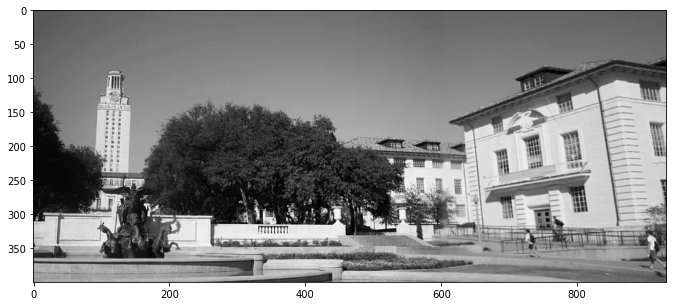

In [1904]:
# diversamente da prima si è calcolata l'immagine filtrata solo sulla porzione interessata
blur_zone = cv.medianBlur(result[:, (im1.shape[1] - 5):(im1.shape[1] + 5) ],5)
result[:, (im1.shape[1] - 5):(im1.shape[1] + 5) ] = blur_zone
plt.imshow(result, cmap='gray'); plt.show()